
=== Training Random Forest ===

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.88      0.91       160
           1       0.89      0.94      0.91       160

    accuracy                           0.91       320
   macro avg       0.91      0.91      0.91       320
weighted avg       0.91      0.91      0.91       320



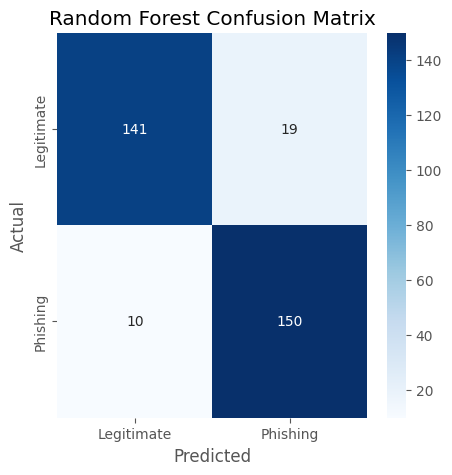


=== Training Naive Bayes ===

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.39      0.56       160
           1       0.62      0.98      0.76       160

    accuracy                           0.69       320
   macro avg       0.79      0.69      0.66       320
weighted avg       0.79      0.69      0.66       320



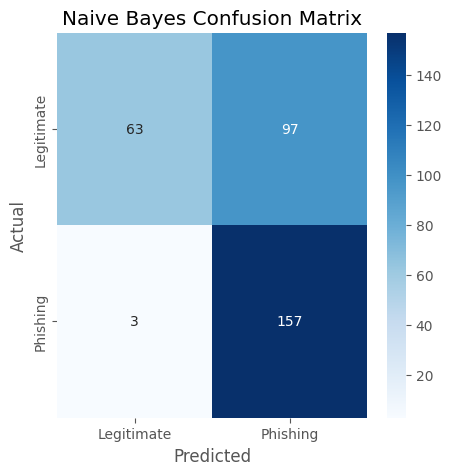


=== Training Logistic Regression ===

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.81      0.85       160
           1       0.83      0.89      0.86       160

    accuracy                           0.85       320
   macro avg       0.86      0.85      0.85       320
weighted avg       0.86      0.85      0.85       320



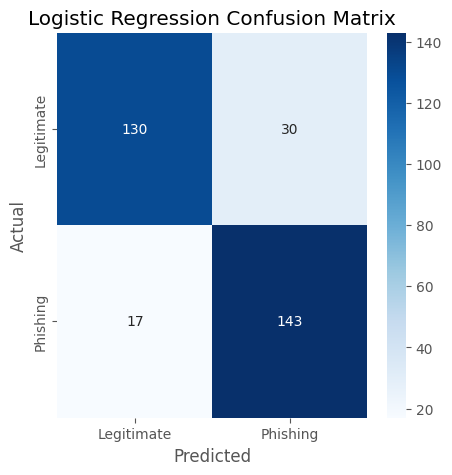


=== Training Decision Tree ===

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       160
           1       0.86      0.89      0.87       160

    accuracy                           0.87       320
   macro avg       0.87      0.87      0.87       320
weighted avg       0.87      0.87      0.87       320



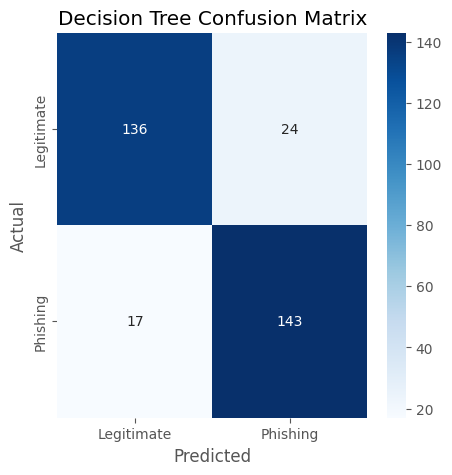

<Figure size 1500x800 with 0 Axes>

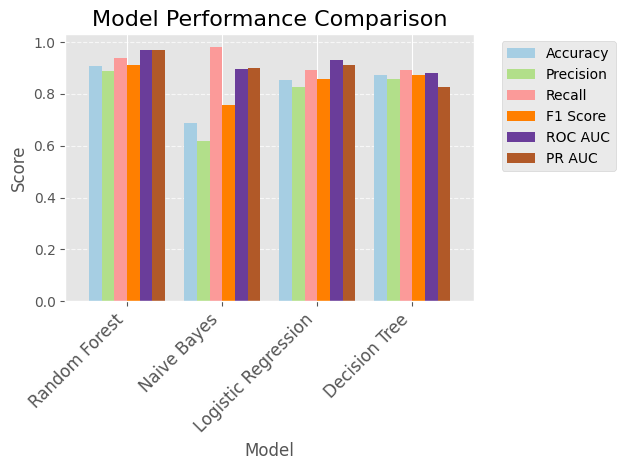

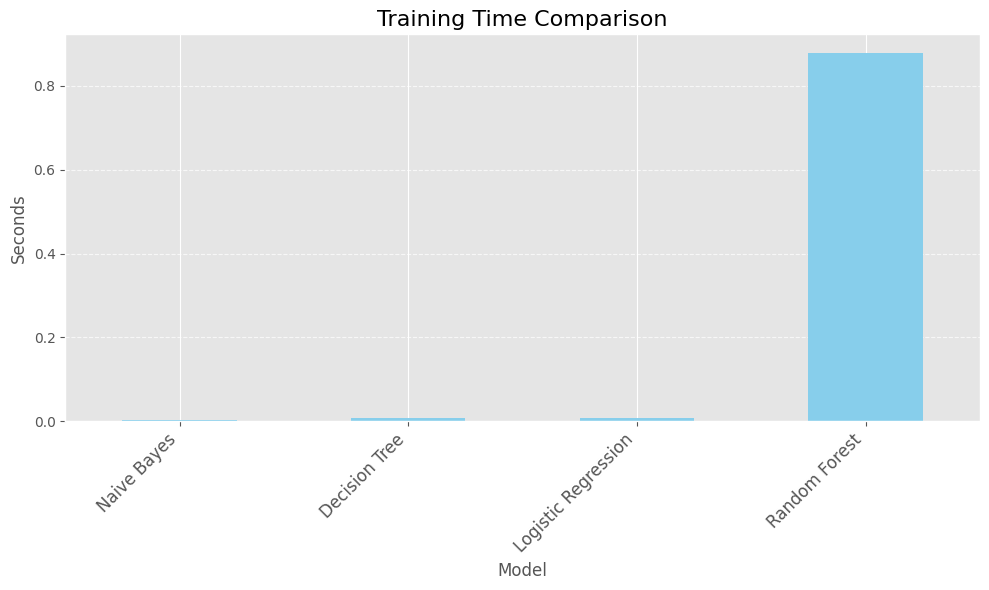

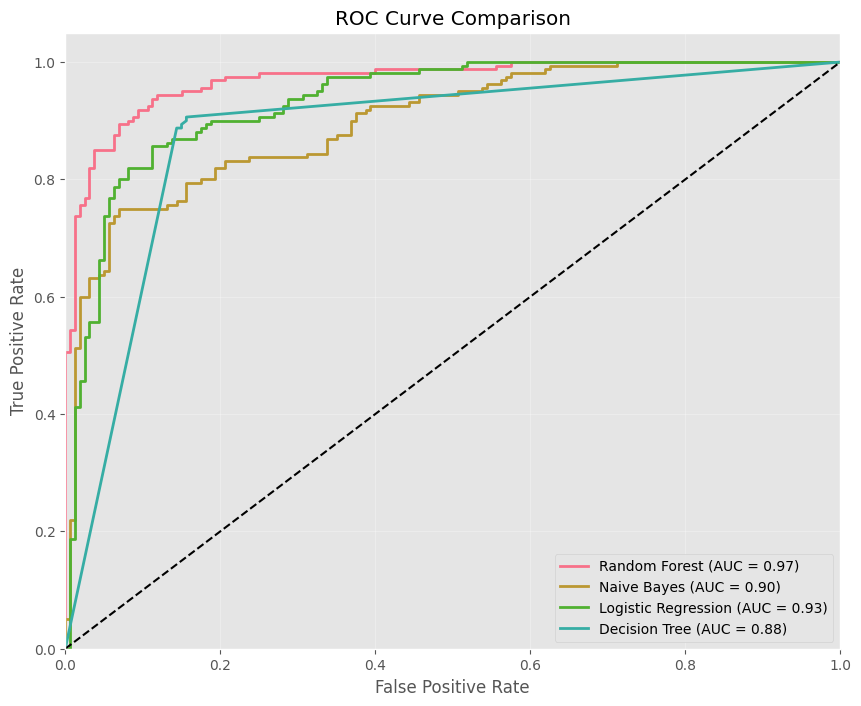

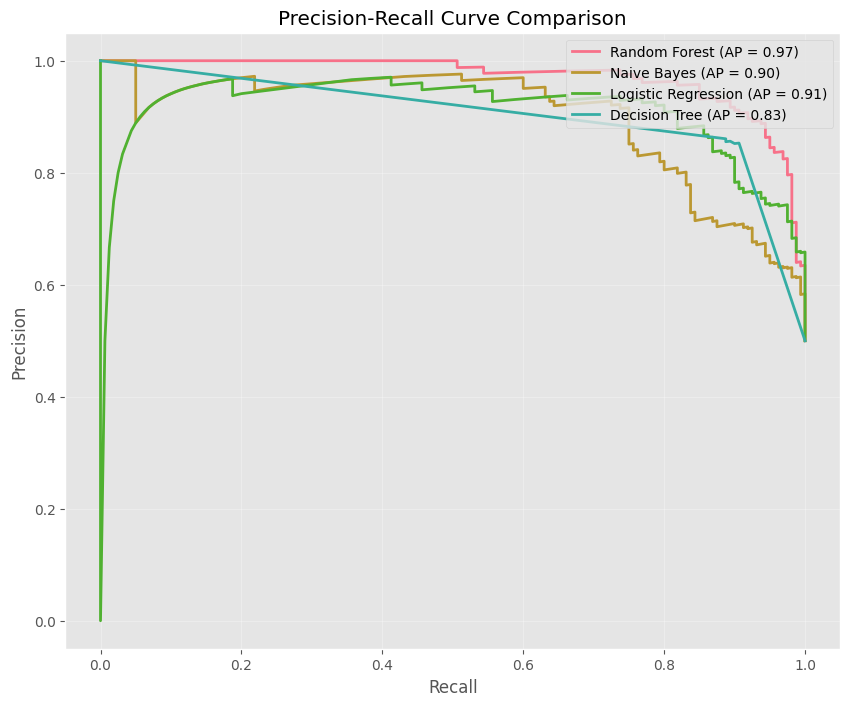

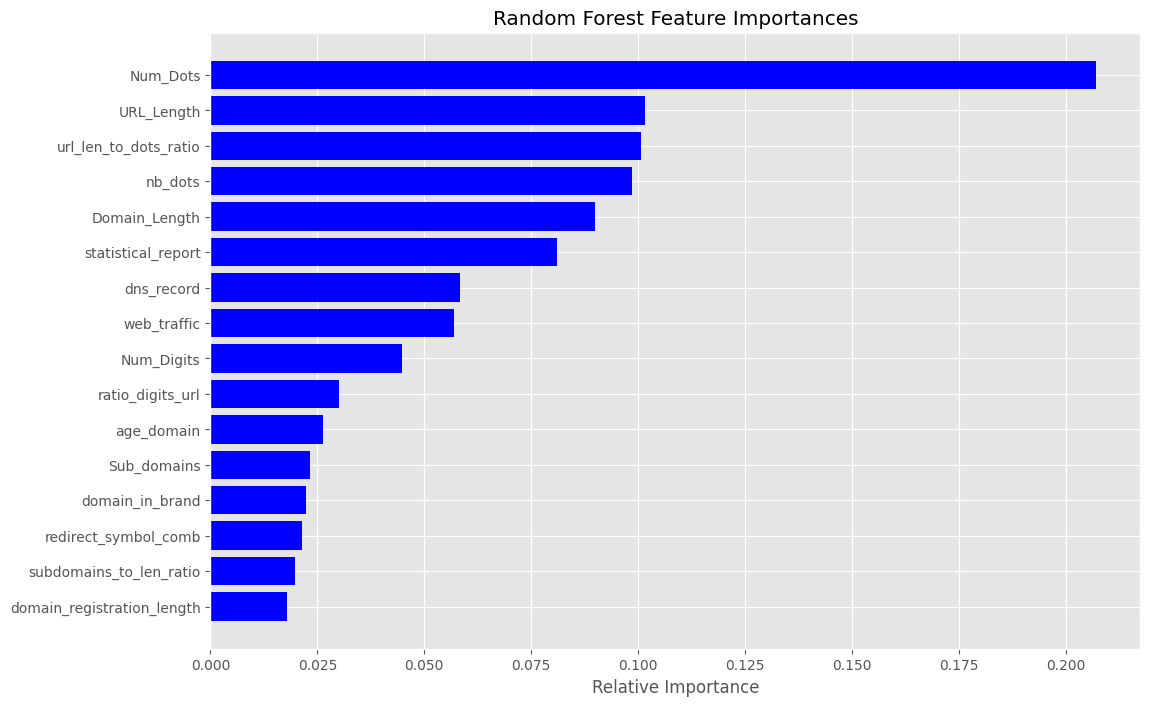

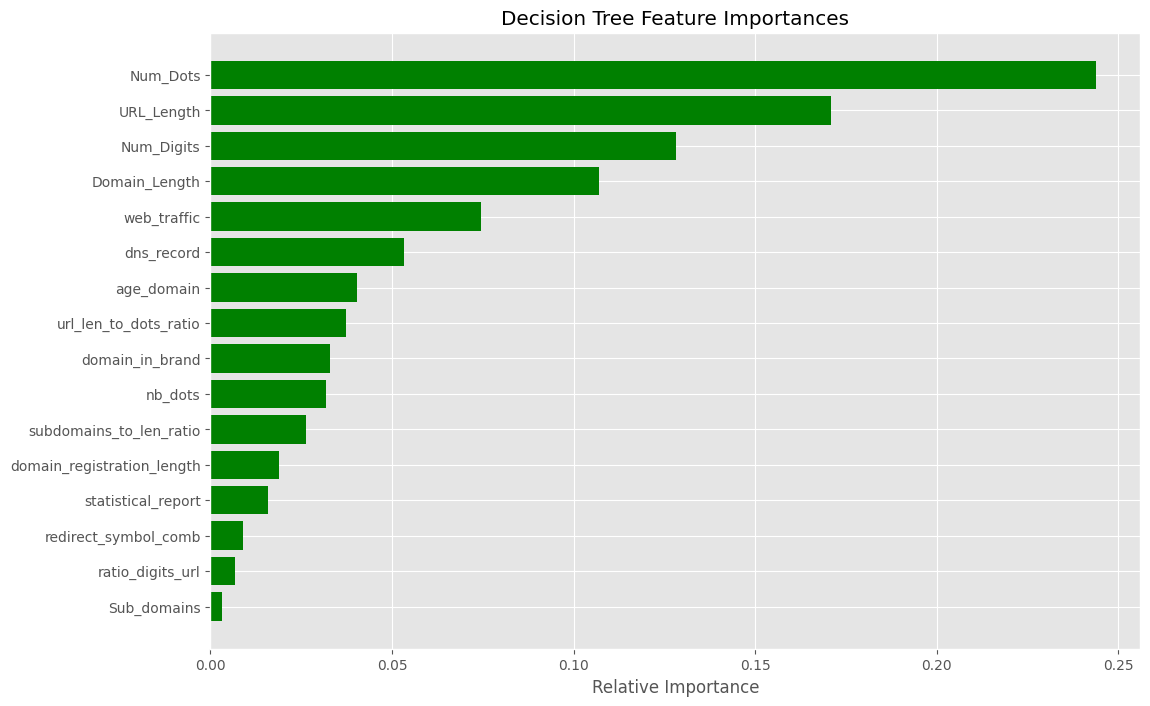


=== Final Model Comparison ===
Sorted by F1 Score:


,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC,Training Time (s)
Model,,,,,,,
Random Forest,0.909375,0.887574,0.93750,0.911854,0.969258,0.971292,0.879115
Decision Tree,0.871875,0.856287,0.89375,0.874618,0.879141,0.826671,0.007108
Logistic Regression,0.853125,0.826590,0.89375,0.858859,0.933008,0.910968,0.008298
Naive Bayes,0.687500,0.618110,0.98125,0.758454,0.897813,0.901249,0.002668


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           confusion_matrix, classification_report, roc_curve, auc,
                           precision_recall_curve, average_precision_score, roc_auc_score)
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel

# Set visualization style
plt.style.use('ggplot')
sns.set_palette("husl")

# Load and prepare data
def load_data():
    phishing_df = pd.read_csv("model_comparision_legitimate.csv")
    legitimate_df = pd.read_csv("model_comparision_phishing.csv")
    
    phishing_df['label'] = 1  # 1 for phishing
    legitimate_df['label'] = 0  # 0 for legitimate
    
    df = pd.concat([phishing_df, legitimate_df], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)
    return df

# Feature engineering
def engineer_features(df):
    # Extract domain features before dropping
    if 'Domain' in df.columns:
        df['Domain_Length'] = df['Domain'].astype(str).apply(len)
        df['Num_Dots'] = df['Domain'].astype(str).apply(lambda x: x.count('.'))
        df['Num_Hyphens'] = df['Domain'].astype(str).apply(lambda x: x.count('-'))
        df['Num_Digits'] = df['Domain'].astype(str).apply(lambda x: sum(c.isdigit() for c in x))
        df['Has_IP'] = df['Domain'].astype(str).apply(lambda x: 1 if any(part.isdigit() for part in x.split('.')) else 0)
    
    # Create interaction features
    if 'URL_Length' in df.columns and 'nb_dots' in df.columns:
        df['url_len_to_dots_ratio'] = df['URL_Length'] / (df['nb_dots'] + 1)
    if 'Sub_domains' in df.columns and 'URL_Length' in df.columns:
        df['subdomains_to_len_ratio'] = df['Sub_domains'] / (df['URL_Length'] + 1)
    if 'ratio_digits_url' in df.columns and 'URL_Length' in df.columns:
        df['digits_to_len_ratio'] = df['ratio_digits_url'] * df['URL_Length']
    
    # Create composite features
    if all(col in df.columns for col in ['Having_IP', 'punycode', 'suspecious_tld']):
        df['suspicious_comb'] = df['Having_IP'] + df['punycode'] + df['suspecious_tld']
    if all(col in df.columns for col in ['Redirection_//_symbol', 'Prefix_suffix_separation']):
        df['redirect_symbol_comb'] = df['Redirection_//_symbol'] + df['Prefix_suffix_separation']
    
    return df

# Preprocess data
def preprocess_data(df):
    # Drop non-numeric columns that can't be used in modeling
    cols_to_drop = ['Domain', 'Path', 'Protocol']
    for col in cols_to_drop:
        if col in df.columns:
            df = df.drop(col, axis=1)
    
    # Handle missing values
    df = df.fillna(0)
    
    # Convert boolean columns to int
    bool_cols = ['Having_@_symbol', 'Having_IP', 'punycode', 'domain_in_brand', 
                'brand_in_path', 'suspecious_tld', 'tiny_url', 'dns_record']
    for col in bool_cols:
        if col in df.columns:
            df[col] = df[col].astype(int)
    
    # Separate features and target
    X = df.drop(['label'], axis=1, errors='ignore')
    y = df['label']
    
    return X, y

# Feature selection
def select_features(X_train, y_train):
    selector = SelectFromModel(
        RandomForestClassifier(n_estimators=100, random_state=42),
        threshold='median'
    )
    selector.fit(X_train, y_train)
    return selector

# Model training and evaluation
def train_and_evaluate(models, X_train, X_test, y_train, y_test):
    results = {
        'Model': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1 Score': [],
        'ROC AUC': [],
        'PR AUC': [],
        'Training Time (s)': []
    }
    
    for name, model in models.items():
        print(f"\n=== Training {name} ===")
        start_time = time.time()
        
        model.fit(X_train, y_train)
        train_time = time.time() - start_time
        
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
        
        # Store metrics
        results['Model'].append(name)
        results['Accuracy'].append(accuracy_score(y_test, y_pred))
        results['Precision'].append(precision_score(y_test, y_pred))
        results['Recall'].append(recall_score(y_test, y_pred))
        results['F1 Score'].append(f1_score(y_test, y_pred))
        results['ROC AUC'].append(roc_auc_score(y_test, y_proba))
        results['PR AUC'].append(average_precision_score(y_test, y_proba))
        results['Training Time (s)'].append(train_time)
        
        # Print classification report
        print(f"\n{name} Classification Report:")
        print(classification_report(y_test, y_pred))
        
        # Plot confusion matrix
        plot_confusion_matrix(y_test, y_pred, name)
    
    return pd.DataFrame(results).set_index('Model')

# Visualization functions
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Legitimate', 'Phishing'], 
                yticklabels=['Legitimate', 'Phishing'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def plot_metrics_comparison(results_df):
    # Metrics comparison
    plt.figure(figsize=(15, 8))
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'PR AUC']
    results_df[metrics].plot(kind='bar', width=0.8, colormap='Paired')
    plt.title('Model Performance Comparison', fontsize=16)
    plt.ylabel('Score', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Training time comparison
    plt.figure(figsize=(10, 6))
    results_df['Training Time (s)'].sort_values().plot(kind='bar', color='skyblue')
    plt.title('Training Time Comparison', fontsize=16)
    plt.ylabel('Seconds', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_roc_pr_curves(models, X_test, y_test):
    # ROC Curve
    plt.figure(figsize=(10, 8))
    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_proba = model.decision_function(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()
    
    # PR Curve
    plt.figure(figsize=(10, 8))
    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_proba = model.decision_function(X_test)
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        avg_precision = average_precision_score(y_test, y_proba)
        plt.plot(recall, precision, lw=2, label=f'{name} (AP = {avg_precision:.2f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve Comparison')
    plt.legend(loc="upper right")
    plt.grid(alpha=0.3)
    plt.show()

# Main execution
def main():
    # Load and prepare data
    df = load_data()
    df = engineer_features(df)
    X, y = preprocess_data(df)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Handle class imbalance
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    
    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_res)
    X_test_scaled = scaler.transform(X_test)
    
    # Feature selection
    selector = select_features(X_train_scaled, y_train_res)
    X_train_selected = selector.transform(X_train_scaled)
    X_test_selected = selector.transform(X_test_scaled)
    
    # Initialize models
    models = {
        "Random Forest": RandomForestClassifier(
            n_estimators=200,
            max_depth=None,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt',
            bootstrap=True,
            class_weight='balanced_subsample',
            random_state=42
        ),
        "Naive Bayes": GaussianNB(),
        "Logistic Regression": LogisticRegression(
            C=1.0,
            penalty='l2',
            solver='liblinear',
            max_iter=1000,
            class_weight='balanced',
            random_state=42
        ),
        "Decision Tree": DecisionTreeClassifier(
            criterion='gini',
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            max_features=None,
            class_weight='balanced',
            random_state=42
        )
    }
    
    # Train and evaluate models
    results_df = train_and_evaluate(models, X_train_selected, X_test_selected, y_train_res, y_test)
    
    # Visualizations
    plot_metrics_comparison(results_df)
    plot_roc_pr_curves(models, X_test_selected, y_test)
    
    # Feature importance for Random Forest
    if "Random Forest" in models:
        rf = models["Random Forest"]
        importances = rf.feature_importances_
        indices = np.argsort(importances)[::-1]
        features = X.columns[selector.get_support()]
        
        plt.figure(figsize=(12, 8))
        plt.title("Random Forest Feature Importances")
        plt.barh(range(len(indices)), importances[indices], color='b', align="center")
        plt.yticks(range(len(indices)), [features[i] for i in indices])
        plt.xlabel("Relative Importance")
        plt.gca().invert_yaxis()
        plt.show()
    
    # Also plot feature importance for Decision Tree
    if "Decision Tree" in models:
        dt = models["Decision Tree"]
        importances = dt.feature_importances_
        indices = np.argsort(importances)[::-1]
        features = X.columns[selector.get_support()]
        
        plt.figure(figsize=(12, 8))
        plt.title("Decision Tree Feature Importances")
        plt.barh(range(len(indices)), importances[indices], color='g', align="center")
        plt.yticks(range(len(indices)), [features[i] for i in indices])
        plt.xlabel("Relative Importance")
        plt.gca().invert_yaxis()
        plt.show()
    
    # Print final results
    print("\n=== Final Model Comparison ===")
    print("Sorted by F1 Score:")
    display(results_df.sort_values('F1 Score', ascending=False))

if __name__ == "__main__":
    main()